In [6]:
import numpy as np
import argparse
import torch
import cv2 as cv

from natsort import natsorted

import os
import os.path as p

from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F

import pandas as pd

import utils
import data.datasets as data

import matplotlib.pyplot as plt

whole_dataset = data.get_whole_dataset('spleen')

In [9]:
image, label = whole_dataset.get_item_np(0)

In [11]:
padding = 0

In [12]:
original_size = label.shape[:2]

label_th = label.copy()
label_th[label_th > 0.5] = 1
label_th[label_th <= 0.5] = 0
label_th = label_th.astype(np.uint8)
bbox = cv.boundingRect(label_th)

x, y, w, h = bbox

x = max(0, x - padding)
y = max(0, y - padding)
w = min(w + 2 * padding, label_th.shape[1] - x)
h = min(h + 2 * padding, label_th.shape[0] - y)

padding_left = max(0, padding - x)
padding_right = max(0, padding - (original_size[1] - (x + w)))
padding_top = max(0, padding - y)
padding_bottom = max(0, padding - (original_size[0] - (y + h)))

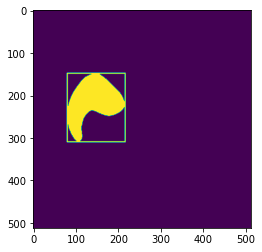

In [13]:
plt.imshow(label)
cv.rectangle(label, (x, y), (x + w, y + h), 1, 2)
plt.imshow(label)

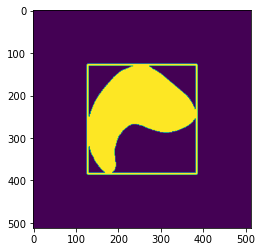

In [28]:
scale_x = original_size[1] / w
scale_y = original_size[0] / h
M = np.array([[scale_x, 0, -x * scale_x], [0, scale_y, -y * scale_y]])

M[0, 2] += 0.5 * original_size[1]
M[1, 2] += 0.5 * original_size[0]
M *= 0.5

label_t = cv.warpAffine(label, M, (label.shape[1], label.shape[0]))
plt.imshow(label_t)

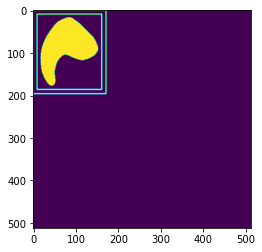

In [79]:
scale_x = original_size[1] / w
scale_y = original_size[0] / h
M = np.array([[1, 0, -x], [0, 1, -y]], dtype=np.float32)

label_t = cv.warpAffine(label, M, (label.shape[1] + padding_left + padding_right, label.shape[0] + padding_top + padding_bottom))
plt.imshow(label_t)

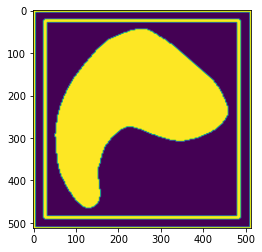

In [99]:
# convert to [-1, 1]
x_t = (x + w / 2) / label.shape[1] * 2 - 1
y_t = (y + h / 2) / label.shape[0] * 2 - 1

theta = np.array([[1 / scale_x, 0, x_t], [0, 1 / scale_y, y_t]])

theta = torch.from_numpy(theta).unsqueeze(0).float()

label_tensor = torch.from_numpy(label).unsqueeze(0).unsqueeze(0).float()

grid = F.affine_grid(theta, label_tensor.size(), align_corners=False)
label_t_torch = F.grid_sample(label_tensor, grid, align_corners=False).squeeze().squeeze().numpy()

plt.imshow(label_t_torch)

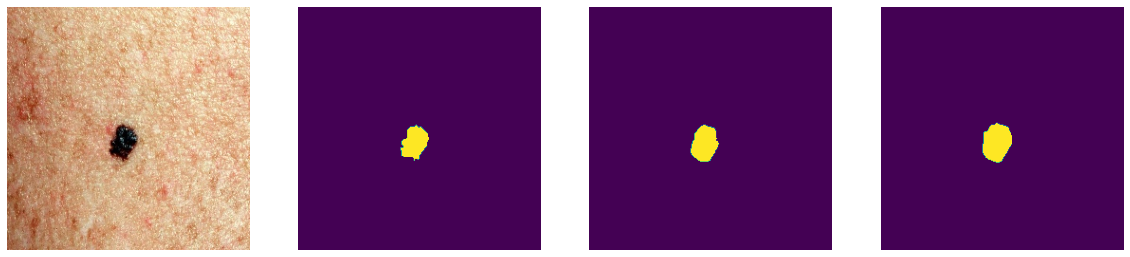

In [75]:
for i, (x, y) in enumerate(whole_dataset):
  if i < 70:
    continue
  x = x.squeeze().numpy().transpose(1, 2, 0) + 0.5
  y = y.squeeze().numpy()
  utils.show_images_row([x, y, preds_unet[i], preds_stnunet[i]], figsize=(20, 5))
  break

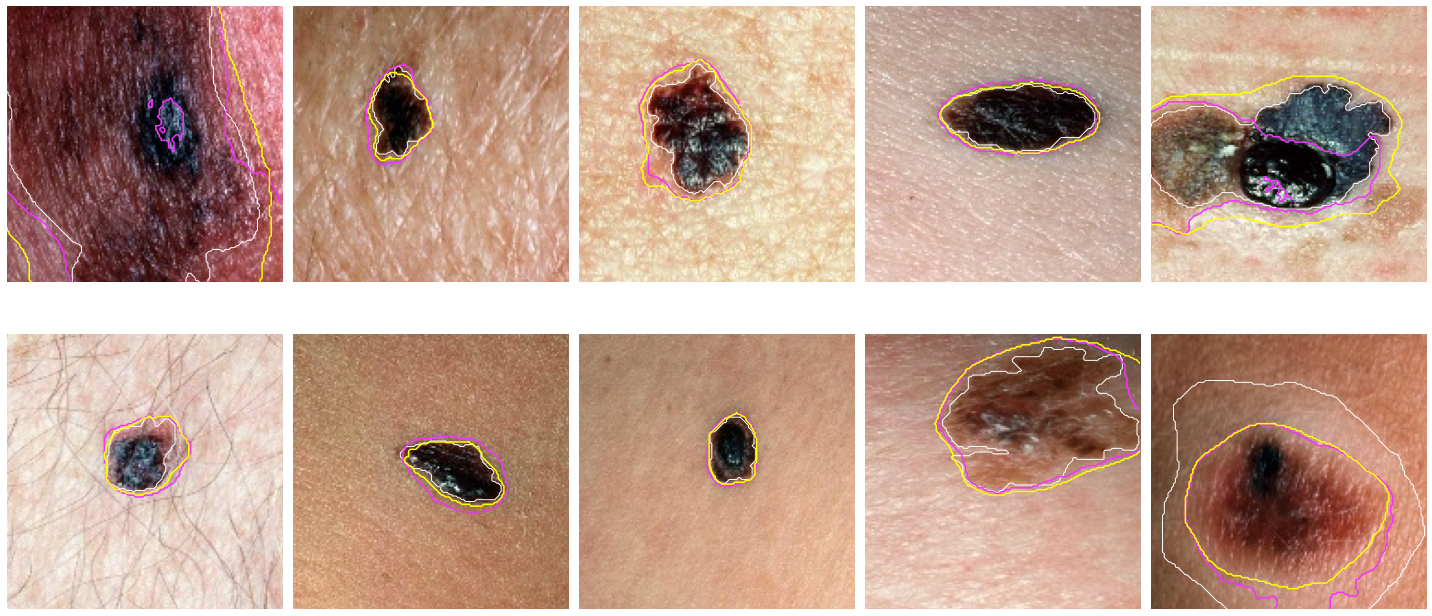

In [120]:
import matplotlib.pyplot as plt
from skimage import measure

indices = range(63,93,3)
fig, axs = plt.subplots(2, len(indices) // 2, figsize=(20, 10))
axs = axs.flatten()

for idx, ax in zip(indices, axs):
    ax.axis('off')
    x = whole_dataset[idx][0].squeeze().numpy().transpose(1, 2, 0) + 0.5
    y = whole_dataset[idx][1].squeeze().numpy()
    y_unet = preds_unet[idx]
    y_stnunet = preds_stnunet[idx]

    y_contours = measure.find_contours(y, 0.5)
    unet_contours = measure.find_contours(y_unet, 0.5)
    stnunet_contours = measure.find_contours(y_stnunet, 0.5)

    ax.imshow(x)

    for contour in y_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='white')

    for contour in unet_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='#F433FF')

    for contour in stnunet_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='yellow')

    ax.axis([50, 200, 50, 200])

plt.tight_layout()
plt.savefig('plots/output.png', bbox_inches='tight')

In [193]:
import pandas as pd
import os
from scipy.stats import ranksums
import scipy.stats as st
import numpy as np

results_folder = 'results'
result_files = os.listdir(results_folder)

datasets = ['dermis', 'isic', 'dermquest']
results = []
dataset_combinations = []

for dataset_train in datasets:
  dataset_result_files = [f for f in result_files if f'train={dataset_train}' in f]
  dataset_result_files.sort()

  for dataset_test in datasets:
    dataset_test_files = [f for f in dataset_result_files if f'test={dataset_test}' in f]
    dataset_test_files.sort(reverse=True)

    dfs = []

    for f in dataset_test_files:
      result_df = pd.read_csv(os.path.join(results_folder, f))
      dfs.append(result_df)

      f = f.replace('.csv', '')
      train_dataset = f.split('_')[1].split('=')[-1]
      test_dataset = f.split('_')[2].split('=')[-1]

      if train_dataset == 'dermis':
        train_dataset = 'DermIS'
      elif train_dataset == 'isic':
        train_dataset = 'ISIC'
      elif train_dataset == 'dermquest':
        train_dataset = 'DermQuest'

      if test_dataset == 'dermis':
        test_dataset = 'DermIS'
      elif test_dataset == 'isic':
        test_dataset = 'ISIC'
      elif test_dataset == 'dermquest':
        test_dataset = 'DermQuest'

    if len(dfs) > 1:
      dataset_combinations.append((train_dataset, test_dataset))
      results.append(dfs)

unet_train=dermis_test=isic.csv
stnunet_train=dermis_test=isic.csv
unet_train=dermis_test=dermquest.csv
stnunet_train=dermis_test=dermquest.csv
unet_train=isic_test=dermis.csv
stnunet_train=isic_test=dermis.csv
unet_train=isic_test=dermquest.csv
stnunet_train=isic_test=dermquest.csv
unet_train=dermquest_test=dermis.csv
stnunet_train=dermquest_test=dermis.csv
unet_train=dermquest_test=isic.csv
stnunet_train=dermquest_test=isic.csv


In [176]:
results_df = pd.DataFrame(columns=['dataset_combination', 'U-Net', 'STN+U-Net'])
for result_idx, (unet, stnunet) in enumerate(results):
  dataset_combination = dataset_combinations[result_idx]
  for idx in range(len(unet)):
    results_df = results_df.append({
      'dataset_combination': f'{dataset_combination[0]} -> {dataset_combination[1]}', 
      'U-Net': unet.iloc[idx]['dsc'],
      'STN+U-Net': stnunet.iloc[idx]['dsc']
    }, ignore_index=True)

/tmp/ipykernel_115651/2197120681.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_115651/2197120681.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_115651/2197120681.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_115651/2197120681.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/tmp/ipykernel_115651/2197120681.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


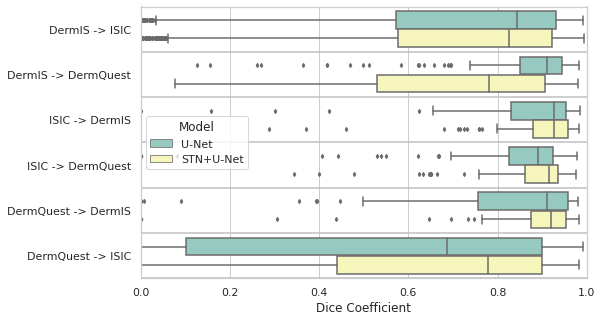

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
melted = pd.melt(results_df, ['dataset_combination'], var_name='Model', value_name='DSC')
ax = sns.boxplot(x='DSC', y="dataset_combination", hue="Model", data=melted, palette="Set3", orient='h', showfliers=True, fliersize=3)
ax.set_ylabel('')
ax.set_xlabel('Dice Coefficient')
ax.set_xlim(0, 1)
[ax.axhline(y+.5,color='0.75') for y in ax.get_yticks()]
plt.savefig('plots/boxplot.pdf', bbox_inches='tight', dpi=200)

  dataset_combination  Model       DSC
0      DermIS -> ISIC  U-Net  0.595754
1      DermIS -> ISIC  U-Net  0.947048
2      DermIS -> ISIC  U-Net  0.857725
3      DermIS -> ISIC  U-Net  0.920793
4      DermIS -> ISIC  U-Net  0.382877


(0.0, 1.0)

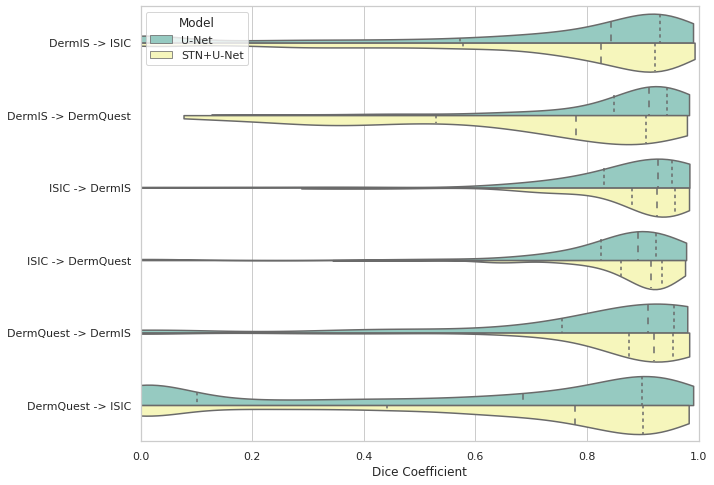

In [192]:
# violin plot
plt.figure(figsize=(10, 8))

melted = pd.melt(results_df, ['dataset_combination'], var_name='Model', value_name='DSC')
melted = pd.DataFrame(melted.to_dict())
#melted['dataset_combination'] = melted['dataset_combination'].map(combination_mapping)
#melted['Model'] = melted['Model'].map(model_mapping)
print(melted.head())
ax = sns.violinplot(y="dataset_combination", x='DSC', hue='Model', data=melted, palette="Set3", split=True, scale='width', inner='quartile', cut=0)
ax.set_ylabel('')
ax.set_xlabel('Dice Coefficient')
ax.set_xlim(0, 1)